# Bake-off: The semantic orientation method

__Important__: This isn't being run as a bake-off this year. It's included in the repository in case people want to do additional exploration or incorporate this kind of evaluation into a project.

In [3]:
__author__ = "Morgan Bryant"
__version__ = "CS224u, Stanford, Spring 2018 term"

In [4]:
from collections import defaultdict
import csv
import importlib
import numpy as np
import os
import pandas as pd
from scipy.stats import pearsonr, spearmanr
import vsm
from mittens import GloVe as glove

In [5]:
default_seeds1 = ('bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'),
default_seeds2 = ('good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior'),

def semantic_orientation(
        df,        
        seeds1=default_seeds1,
        seeds2=default_seeds2,
        distfunc=vsm.cosine):    
    """No frills implementation of the semantic Orientation (SO) method of 
    Turney and Littman. `seeds1` and `seeds2` should be representative members 
    of two intutively opposing semantic classes. The method will then try 
    to rank the vocabulary by its relative association with each seed set.
        
    Parameters
    ----------
    df : pd.DataFrame
        The matrix used to derive the SO ranking.           
    seeds1 : tuple of str
        The default is the negative seed set of Turney and Littman.        
    seeds2 : tuple of str
        The default is the positive seed set of Turney and Littman.        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors. 
    
    Returns
    -------    
    pd.Series
        The vocabulary ranked according to the SO method, with words 
        closest to `seeds1` at the top and words closest to `seeds2` at the 
        bottom.
    
    """
    rownames = set(df.index)
    # Check that the seed sets are in the vocabulary, filtering
    # where necessary, and warn the user about exclusions:
    seeds1 = _value_check(seeds1, "seeds1", rownames)
    seeds2 = _value_check(seeds2, "seeds2", rownames)
    
    # Subframes for the two seeds-sets
    sm1 = df.loc[seeds1]
    sm2 = df.loc[seeds2]
    
    # Core semantic orientation calculation:
    def row_func(row):
        val1 = sm1.apply(lambda x: distfunc(row, x), axis=1).sum()
        val2 = sm2.apply(lambda x: distfunc(row, x), axis=1).sum()
        return val1 - val2
    
    scores = df.apply(row_func, axis=1)
    return scores.sort_values(ascending=False)

def _value_check(ss, name, rownames):
    new = set()
    for w in ss:
        if w not in rownames:
            print("Warning: {} not in {}".format(w, name))
        else:
            new.add(w)
    return new

def load_warriner_lexicon(src_filename, df=None):
    """Read in 'Ratings_Warriner_et_al.csv' and optionally restrict its 
    vocabulary to items in `df`.
    
    Parameters
    ----------
    src_filename : str
        Full path to 'Ratings_Warriner_et_al.csv'
    df : pd.DataFrame or None
        If this is given, then its index is intersected with the 
        vocabulary from the lexicon, and we return a lexicon 
        containing only values in both vocabularies.
        
    Returns
    -------
    pd.DataFrame
    
    """
    lexicon = pd.read_csv(src_filename, index_col=0)
    lexicon = lexicon[['Word', 'V.Mean.Sum', 'A.Mean.Sum', 'D.Mean.Sum']]
    lexicon = lexicon.set_index('Word').rename(
        columns={'V.Mean.Sum': 'Valence', 
                 'A.Mean.Sum': 'Arousal', 
                 'D.Mean.Sum': 'Dominance'})
    if df is not None:
        shared_vocab = sorted(set(lexicon.index) & set(df.index))
        lexicon = lexicon.loc[shared_vocab]
    return lexicon

def evaluation(lexicon, so, colname='Valence', metric=pearsonr):
    lexicon['so'] = so
    rho, pvalue = metric(lexicon['so'], lexicon[colname])
    print("{0:}'s r: {1:0.3f}".format(metric.__name__, rho))

In [6]:
''' Load data '''
this_dir = os.getcwd()
data_home = 'vsmdata'
imdb20 = pd.read_csv(
    os.path.join(data_home, 'imdb_window20-flat.csv.gz'), index_col=0)
imdb5 = pd.read_csv(
    os.path.join(data_home, 'imdb_window5-scaled.csv.gz'), index_col=0)
print(imdb20.shape, imdb5.shape)
# gigaword 5
# gigaword 20

lexicon = load_warriner_lexicon(
    os.path.join(data_home, 'Ratings_Warriner_et_al.csv'),
    imdb20) # imdb20 has same shape as imdb5

(5000, 5000) (5000, 5000)


In [267]:
#ABC.apply(vsm.length_norm, axis=1)
imdb20_tmp = imdb20.copy()
imdb20_tmp.apply(vsm.length_norm, axis=1)

#imdb20_tmp.apply(vsm.length_norm, axis=0)
#print(imdb20_tmp.mean().tail(), imdb20.mean().tail())

,!,"""",#,$,%,&,',(,),);,...,zinc,zloty,zombie,zombies,zoo,,,´,é,és
!,0.999871,0.001772,2.304569e-05,2.457429e-05,0.000020,0.000064,0.000368,0.000783,0.000844,4.342158e-06,...,1.272847e-09,0.000000e+00,1.612548e-05,2.109472e-05,4.222693e-07,1.367464e-05,1.927502e-06,2.096423e-05,4.904177e-06,1.647398e-06
"""",0.000618,0.999828,7.313002e-06,5.460419e-06,0.000006,0.000120,0.000370,0.001115,0.000744,4.898428e-06,...,2.362610e-08,0.000000e+00,2.640939e-05,1.020854e-05,9.243449e-07,1.726061e-05,3.239039e-06,1.301307e-05,1.214806e-05,3.314094e-06
#,0.002111,0.002226,9.998130e-01,1.474467e-03,0.001094,0.000582,0.000557,0.001397,0.001145,2.017502e-06,...,0.000000e+00,0.000000e+00,3.760818e-04,1.800736e-06,2.162130e-06,1.793911e-05,5.275154e-06,3.215993e-06,2.277787e-05,0.000000e+00
$,0.001605,0.001216,1.046889e-03,9.998719e-01,0.000734,0.000445,0.000274,0.001257,0.000808,1.006404e-06,...,0.000000e+00,0.000000e+00,1.127754e-05,1.141211e-06,2.575345e-07,2.022470e-05,2.559265e-06,5.836653e-06,2.540194e-06,0.000000e+00
%,0.001226,0.001076,6.986101e-04,6.525929e-04,0.999805,0.000410,0.000236,0.000805,0.000608,2.287742e-06,...,0.000000e+00,0.000000e+00,7.685980e-06,5.912298e-06,3.166545e-07,2.777303e-05,1.144995e-05,7.367727e-06,7.923053e-06,8.597879e-06
&,0.000522,0.003224,5.277792e-05,5.710312e-05,0.000058,0.999899,0.000997,0.001652,0.001256,7.155332e-06,...,0.000000e+00,0.000000e+00,1.370830e-05,1.135107e-05,8.156604e-07,1.798994e-05,3.225665e-06,2.303187e-06,1.198409e-05,3.349351e-06
',0.000429,0.001238,6.555429e-06,4.041619e-06,0.000005,0.000128,0.999837,0.001032,0.000716,4.716526e-06,...,7.758802e-08,0.000000e+00,2.882692e-05,8.385501e-06,6.890706e-07,3.332950e-05,5.011051e-06,1.357027e-06,3.362484e-05,4.239031e-06
(,0.000498,0.002555,1.059028e-05,1.295297e-05,0.000009,0.000141,0.000676,0.999869,0.009322,3.683197e-05,...,0.000000e+00,1.639580e-08,2.273816e-05,9.305146e-06,1.861583e-06,2.796921e-05,3.916552e-06,6.282681e-06,1.860563e-05,4.851699e-06
),0.000638,0.001529,9.235046e-06,9.156571e-06,0.000007,0.000115,0.000454,0.012388,0.999865,1.620531e-06,...,6.075407e-09,0.000000e+00,1.506056e-05,6.112150e-06,1.599599e-06,2.081060e-05,3.725495e-06,4.261016e-06,1.356982e-05,1.892541e-06
);,0.000424,0.001239,2.008450e-06,1.381222e-06,0.000004,0.000081,0.000370,0.005197,0.000207,9.999662e-01,...,0.000000e+00,0.000000e+00,3.351002e-06,2.906622e-06,1.284936e-06,3.611993e-05,1.642270e-06,1.277687e-06,8.379148e-06,5.554629e-07


In [7]:
imdb20_n0 = imdb20.apply(vsm.length_norm, axis=1)
imdb20_n01 = imdb20_n0.apply(vsm.length_norm, axis=0)
imdb20_n01_ppmi = vsm.pmi(imdb20_n01)
imdb20_n01_ppmi = imdb20_n01_ppmi.apply(vsm.length_norm, axis=1)
imdb20_n01_ppmi = imdb20_n01_ppmi.apply(vsm.length_norm, axis=0)

In [206]:
default_seeds1


(('bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'),)

In [8]:
''' Morgan Bryant: this is a small bootstrapping algorithm
that seeks to expand the given default seeds (considered 
"paragons") by operating on a differentially modified dataset.'''
from numpy import random
import bakeoff_semantic_orientation as bso
importlib.reload(bso)

# Operate on the seed sets
laplace = 1.0
nsteps = 2
nadditions = 8
def dist_factor(step):
    return 1.0;#step**0.5
    #return 1+nsteps-step

DF = imdb20_n01_ppmi
'''seeds1 = list(default_seeds1[0])
def randrm(S, n='rand'):
    seeds = list(S[0])
    if n=='rand':
        for i in reversed(range(len(seeds))):
            if random.random()<0.5:
                seeds.pop(i)
    else: 
        seeds = list(random.choice(seeds, size=n, replace=False))
    if len(seeds)==0 or len(seeds)==len(S[0]):
        return randrm(S) # try again
    print("Seeds: ",seeds)
    return seeds'''

#thin_seeds1 = (tuple(randrm(default_seeds1)),)           
#thin_seeds2 = (tuple(randrm(default_seeds2, len(thin_seeds1[0]))),)         
empir_seeds1 = (('poor', 'negative','bad'),)
empir_seeds2 = (('excellent','positive','good'),)

df = vsm.pmi(imdb20)
ss1_counts, ss1 = bso.bootstrap(empir_seeds1, df, 'p', 
                     dist_factor, laplace, nsteps, nadditions)
ss2_counts, ss2 = bso.bootstrap(empir_seeds2, df, 'n',
                      dist_factor, laplace, nsteps, nadditions)
  

orig set: (('poor', 'negative', 'bad'),)
orig ssd: defaultdict(<function bootstrap.<locals>.<lambda> at 0x7f1f29e68378>, {'poor': 1.0, 'negative': 1.0, 'bad': 1.0})
depth 0 on ['poor', 'negative', 'bad'] :
current set size: p 0 21
depth 1 on ['poor', 'negative', 'bad', 'awful', 'terrible', 'horrible', 'worst', 'worse', 'stupid', 'lame', 'poorly', 'laughable', 'weak', 'mediocre', 'positive', 'comments', 'reviews', 'reviewers', 'imdb', 'comment', 'critics'] :
current set size: p 1 55
orig set: (('excellent', 'positive', 'good'),)
orig ssd: defaultdict(<function bootstrap.<locals>.<lambda> at 0x7f1f29e68730>, {'excellent': 1.0, 'positive': 1.0, 'good': 1.0})
depth 0 on ['excellent', 'positive', 'good'] :
current set size: n 0 22
depth 1 on ['excellent', 'positive', 'good', 'decent', 'great', 'acting', 'overall', 'pretty', 'solid', 'negative', 'reviews', 'comments', 'feedback', 'reviewers', 'imdb', 'review', 'superb', 'outstanding', 'performances', 'terrific', 'cast', 'brilliant'] :
curren

In [270]:
default_seeds1 = ('bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior')
default_seeds2 = ('good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior')
          
def twinned_randrm():
    l = random.randint(1,len(default_seeds1)-2)
    s_id = random.choice(list(range(len(default_seeds1))),
                              size=l, replace=False)
    print(l, s_id, default_seeds1, default_seeds2)
    def f(sl,sid): return [sl[i] for i in s_id]
    return (f(default_seeds1,s_id),), (f(default_seeds2,s_id),)
                         
thin_seeds1, thin_seeds2 = twinned_randrm()    
print (thin_seeds1, thin_seeds2 )     

2 [4 0] ('bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior') ('good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior')
(['unfortunate', 'bad'],) (['fortunate', 'good'],)


In [ ]:
('nasty','bad','unfortunate','wrong') 
('nice','good','fortunate','correct')

('poor', 'negative','bad')
('excellent','positive','good')

In [19]:
glove_init = glove(alpha=0.9, n=100, xmax=150)
imdb20_glv = glove_init.fit(imdb20_n01_ppmi.values)
imdb20_glv2 = pd.DataFrame(imdb20_glv, index=imdb20.index)
imdb20_ppmi_so = semantic_orientation(imdb20_glv2, default_seeds1, default_seeds2)
evaluation(lexicon, imdb20_ppmi_so, colname='Valence')
evaluation(lexicon, imdb20_ppmi_so, colname='Arousal')
evaluation(lexicon, imdb20_ppmi_so, colname='Dominance')

Iteration 100: error 532.7891

TypeError: sort_values() missing 1 required positional argument: 'by'

In [ ]:
imdb20_lsa = vsm.lsa(imdb20_n01_ppmi, k=150)
imdb20_ppmi_so = semantic_orientation(imdb20_lsa, default_seeds1, default_seeds2)
evaluation(lexicon, imdb20_ppmi_so, colname='Valence')
evaluation(lexicon, imdb20_ppmi_so, colname='Arousal')
evaluation(lexicon, imdb20_ppmi_so, colname='Dominance')

In [14]:
imdb20_ppmi_so = semantic_orientation(imdb20_n01_ppmi, 
                    ('poor', 'negative','bad'), ('excellent','positive','good'))
evaluation(lexicon, imdb20_ppmi_so, colname='Valence')
evaluation(lexicon, imdb20_ppmi_so, colname='Arousal')
evaluation(lexicon, imdb20_ppmi_so, colname='Dominance')

pearsonr's r: 0.329
pearsonr's r: 0.100
pearsonr's r: 0.257


In [292]:
print(len(ss1),len(ss2))

imdb20_ppmi_so = semantic_orientation(imdb20_n01_ppmi, ss1, ss2)
evaluation(lexicon, imdb20_ppmi_so, colname='Valence')
evaluation(lexicon, imdb20_ppmi_so, colname='Arousal')
evaluation(lexicon, imdb20_ppmi_so, colname='Dominance')

55 57
pearsonr's r: 0.317
pearsonr's r: 0.085
pearsonr's r: 0.236


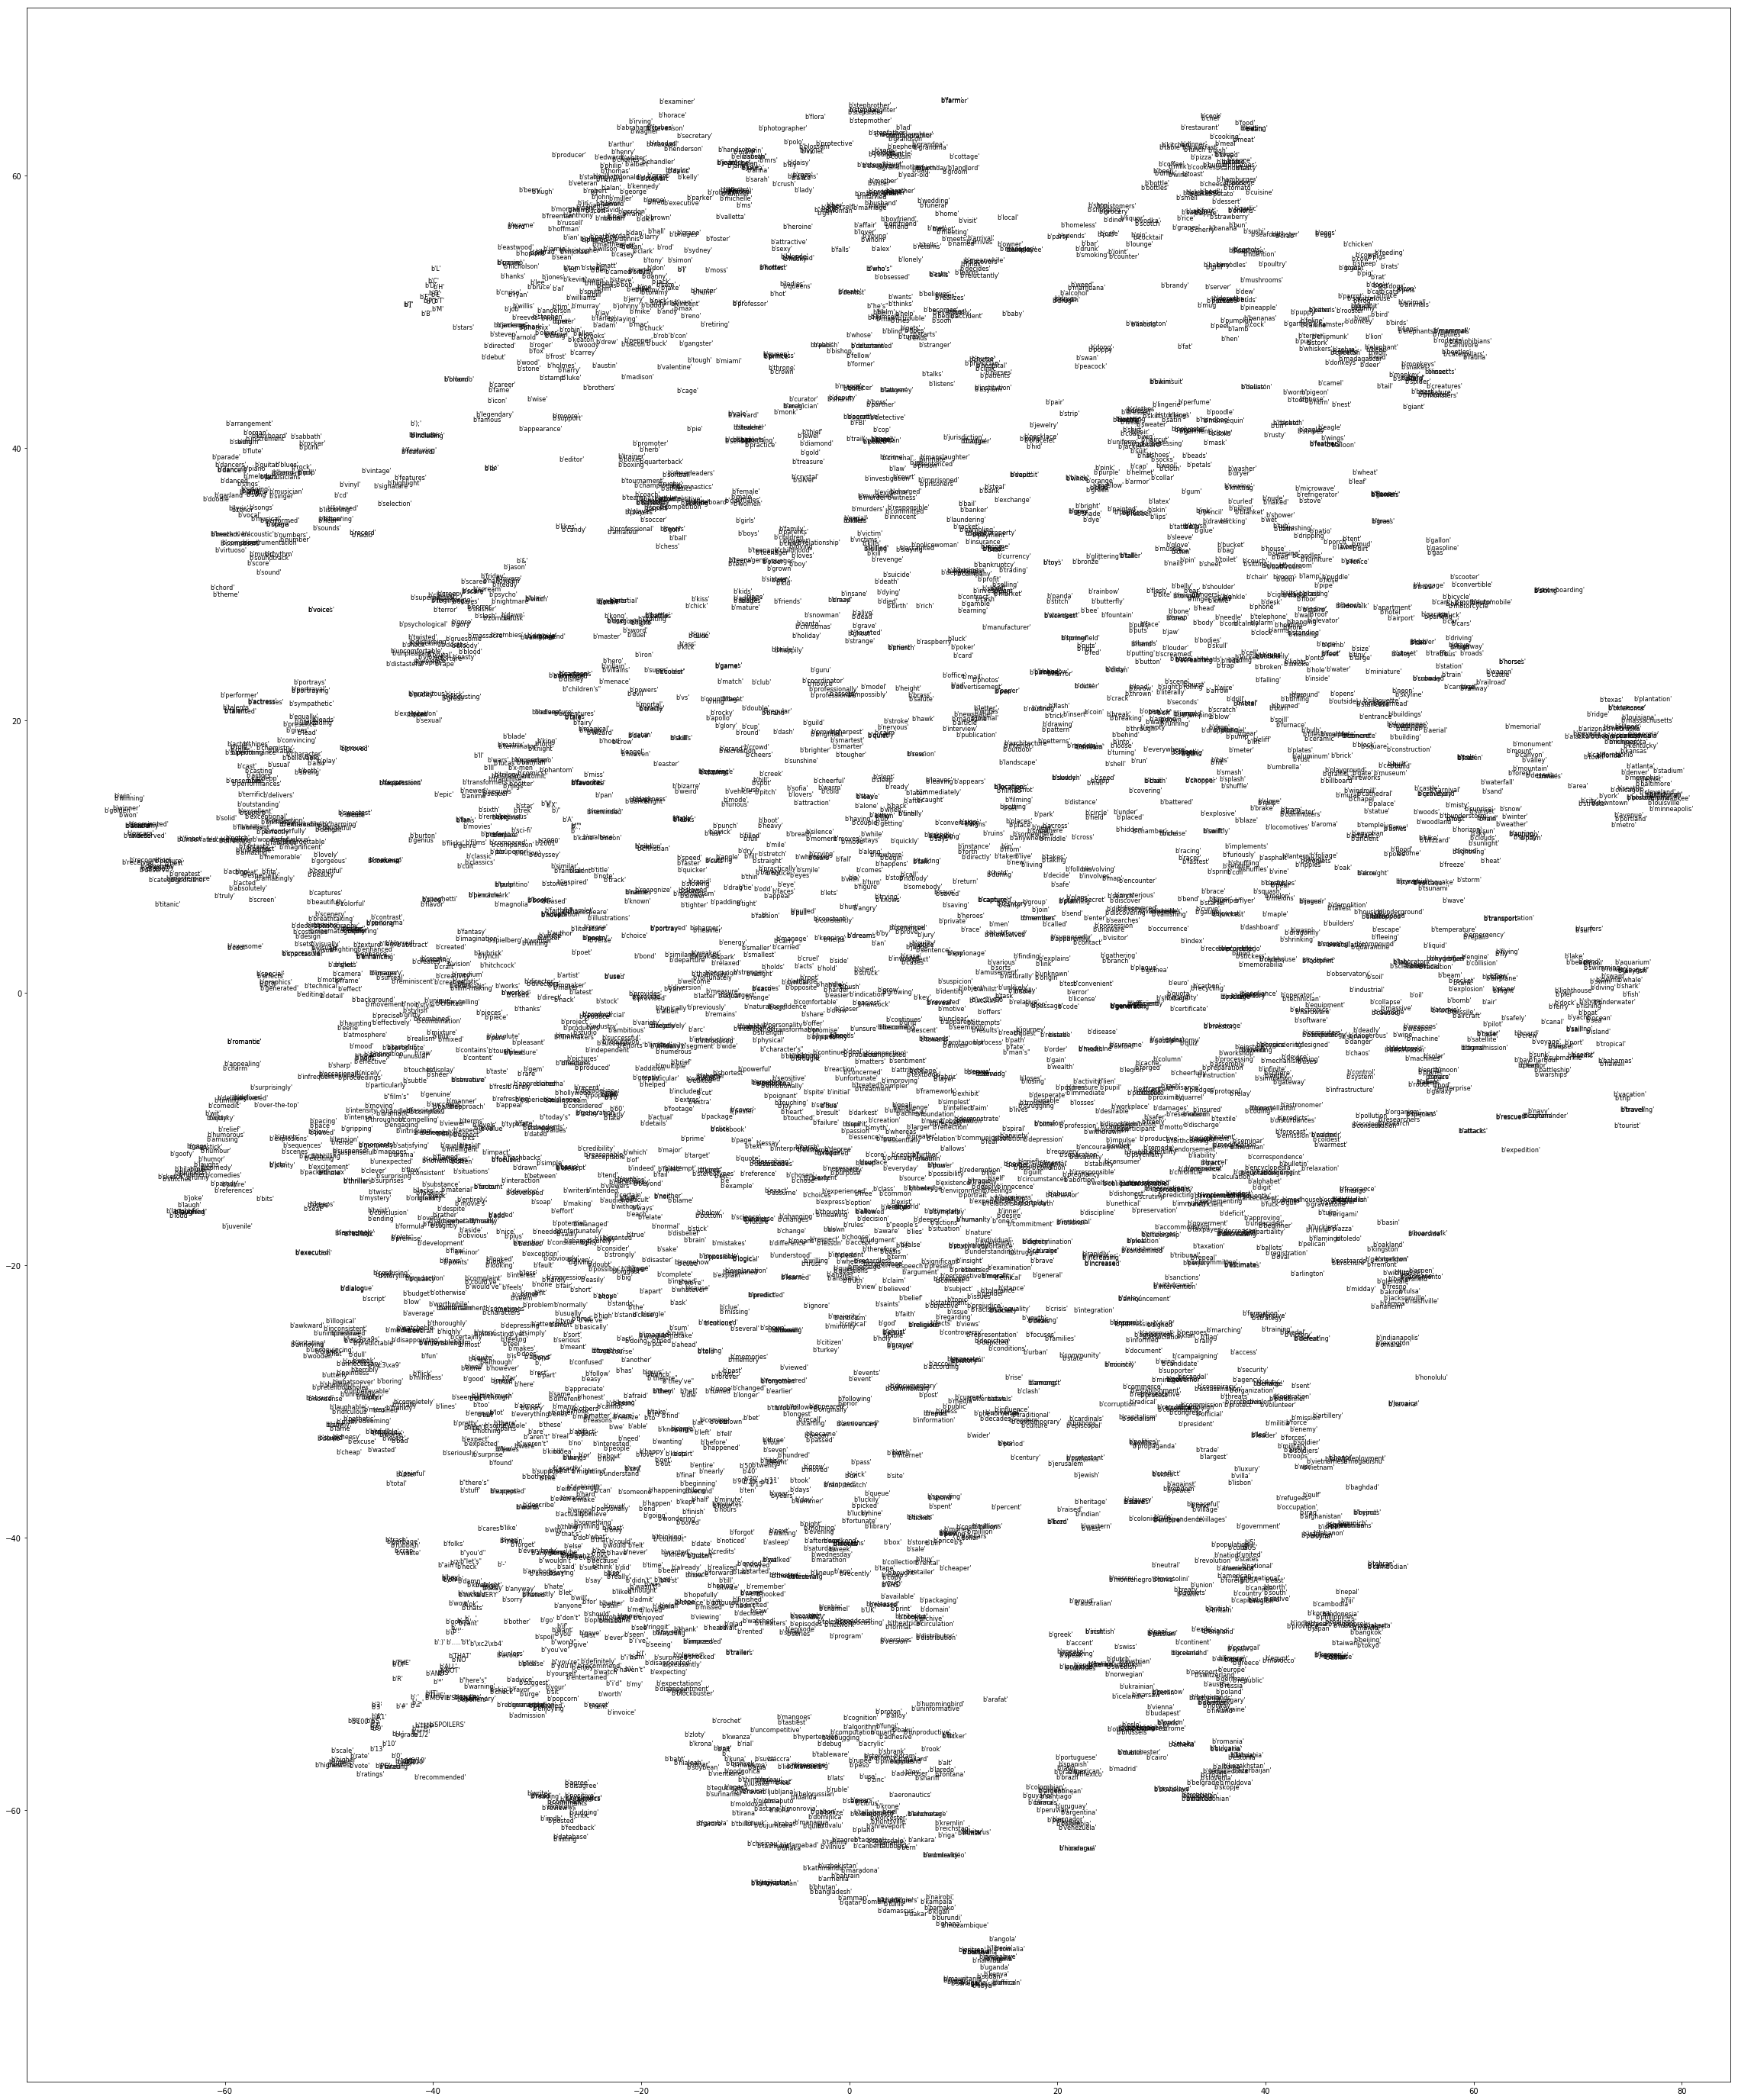

In [293]:
vsm.tsne_viz(df)

## Bake-off submission

1. The name of the count matrix you started with (must be one in `vsmdata`).
1. The seed-sets you used.
1. A description of the steps you took to create your bake-off VSM – must be different from the above baseline.
1. Your Pearson r values for 'Valence', 'Arousal', and 'Dominance'.